Purpose: Run random forest to classify samples as either control or stressed in a single stressor with lots of samples (drought).<br>
Author: Anna Pardo<br>
Date initiated: June 12, 2023

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
# load log TPM matrix (low-variance features already removed with VarianceThreshold)

vttpm_log = pd.read_csv("../../data/logTPM_allsamples_16-May-2023.txt",sep="\t",header="infer")
vttpm_log.head()

,Sample,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,B73xMO17_HII_1_BRB1,1.638809,2.220060,0.0,3.608334,0.000000,3.246090,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B73xMO17_HII_2_BRB3,1.411726,1.015722,0.0,1.467345,0.000000,2.666771,0.0,0.0,0.496737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B73xMO17_HI_2_BRB4,1.525312,0.585677,0.0,1.638883,0.050644,2.615085,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B73xMO17_HII_3_BRB4,1.856313,1.782950,0.0,1.282574,0.059865,2.775211,0.0,0.0,1.116139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B73xMO17_HI_3_BRB6,1.212664,1.257071,0.0,0.000000,0.000000,2.086426,0.0,0.0,0.640717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# load metadata (only columns Sample and Treatment are required)
md = pd.read_csv("../../data/srr_numbers_with_metadata_12-May-2023.csv",sep=",",header="infer",usecols=["BioProject","Sample","Treatment"])
md.head()

,BioProject,Sample,Treatment
0,PRJNA637522,SRR11933261,Drought
1,PRJNA637522,SRR11933272,Drought
2,PRJNA637522,SRR11933250,Drought
3,PRJNA637522,SRR11933029,Control
4,PRJNA637522,SRR11933040,Drought


In [4]:
len(md.index)

2067

In [5]:
# only for this preliminary random forest: drop all non-drought BioProjects
## start by dropping all samples not labeled drought or control
mddc = md[md["Treatment"].isin(["Drought","DroughtRepeat","Control"])]
len(mddc.index)

1444

In [6]:
# now remove all BioProjects that only have control samples
for b in mddc["BioProject"].unique():
    df = mddc[mddc["BioProject"]==b]
    if df["Treatment"].unique()[0] == "Control":
        mddc = mddc[mddc["BioProject"] != b]

In [7]:
mddc.head()

,BioProject,Sample,Treatment
0,PRJNA637522,SRR11933261,Drought
1,PRJNA637522,SRR11933272,Drought
2,PRJNA637522,SRR11933250,Drought
3,PRJNA637522,SRR11933029,Control
4,PRJNA637522,SRR11933040,Drought


In [8]:
# set Control to 0 and any stress to 1
proxy = []
for i in range(len(mddc.index)):
    if mddc.iloc[i,2] == "Control":
        proxy.append(0)
    else:
        proxy.append(1)
mddc["Label"] = proxy

In [9]:
mddc.head()

,BioProject,Sample,Treatment,Label
0,PRJNA637522,SRR11933261,Drought,1
1,PRJNA637522,SRR11933272,Drought,1
2,PRJNA637522,SRR11933250,Drought,1
3,PRJNA637522,SRR11933029,Control,0
4,PRJNA637522,SRR11933040,Drought,1


In [10]:
# merge labels with log TPM
labeled = mddc[["Sample","Label"]].merge(vttpm_log)
labeled.head()

,Sample,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,1,3.760627,1.731651,0.060075,3.800400,2.644723,3.597631,0.494946,0.0,...,0.227968,0.000000,0.0,0.0,0.0,0.389017,0.0,0.000000,0.0,0.000000
1,SRR11933272,1,4.109013,2.039269,0.490802,3.038092,1.537277,1.742518,0.226885,0.0,...,0.148026,0.173611,0.0,0.0,0.0,2.945473,0.0,0.000000,0.0,0.000000
2,SRR11933250,1,3.326079,1.994391,0.000000,2.032962,1.842599,4.103174,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.503415,0.0,0.326679,0.0,1.146231
3,SRR11933029,0,3.201844,1.759475,0.000000,1.447213,1.549133,4.364607,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.244933
4,SRR11933040,1,3.507319,1.925657,0.000000,1.189432,2.254362,4.372791,0.193789,0.0,...,0.236712,0.017435,0.0,0.0,0.0,3.409421,0.0,0.000000,0.0,1.745435


In [11]:
# drop any rows with NAs
labeled.dropna(inplace=True)

In [12]:
len(labeled.index)

825

In [13]:
# set Sample as the index
labeled.set_index("Sample",inplace=True)
labeled.head()

,Label,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR11933261,1,3.760627,1.731651,0.060075,3.800400,2.644723,3.597631,0.494946,0.0,1.086039,...,0.227968,0.000000,0.0,0.0,0.0,0.389017,0.0,0.000000,0.0,0.000000
SRR11933272,1,4.109013,2.039269,0.490802,3.038092,1.537277,1.742518,0.226885,0.0,1.714098,...,0.148026,0.173611,0.0,0.0,0.0,2.945473,0.0,0.000000,0.0,0.000000
SRR11933250,1,3.326079,1.994391,0.000000,2.032962,1.842599,4.103174,0.000000,0.0,1.540259,...,0.000000,0.000000,0.0,0.0,0.0,0.503415,0.0,0.326679,0.0,1.146231
SRR11933029,0,3.201844,1.759475,0.000000,1.447213,1.549133,4.364607,0.000000,0.0,1.389265,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.244933
SRR11933040,1,3.507319,1.925657,0.000000,1.189432,2.254362,4.372791,0.193789,0.0,1.706813,...,0.236712,0.017435,0.0,0.0,0.0,3.409421,0.0,0.000000,0.0,1.745435


In [14]:
labeled["Label"].value_counts()

1    527
0    298
Name: Label, dtype: int64

In [15]:
# data are very biased, we can downsample or upsample
# let's downsample for now
import random

In [16]:
ones_only = labeled[labeled["Label"]==1]

In [17]:
ds = ones_only.sample(n=298, random_state=42)

In [18]:
zeroes_only = labeled[labeled["Label"]==0]

In [19]:
downsampled = pd.concat([ds,zeroes_only])

In [20]:
downsampled["Label"].value_counts()

1    298
0    298
Name: Label, dtype: int64

In [21]:
# Separate features (gene expression values) and target (class labels)
## where X = gene expression values and y = class labels
X = downsampled.drop("Label",axis=1)
y = downsampled["Label"]

In [22]:
# Separate features (gene expression values) and target (class labels)
## where X = gene expression values and y = class labels
X = labeled.drop("Label",axis=1)
y = labeled["Label"]

In [23]:
# Split the data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [24]:
# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=5000, random_state=42)
rf_classifier.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

In [ ]:
# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [25]:
# create dictionary of parameters we want to search
from sklearn.model_selection import RandomizedSearchCV

random_search_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_search_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.7min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   9.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  41.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=  57.8s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  42.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 2.3min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 2.0min
[CV] END bootstrap=True, max_depth

/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.6min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  10.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   8.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  41.8s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time= 1.0min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  50.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 2.2min


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.6min
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  10.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   8.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  42.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time= 1.0min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  52.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.9min


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.9min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  38.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   9.4s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time= 1.0min
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  50.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 3.1min


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.6min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  44.0s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  52.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 3.0min


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.6min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 1.6min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  42.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 2.0min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.2min


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1600; total time= 2.0min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  42.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  37.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  41.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1800; total time= 2.2min
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time= 2.0min


/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/leviathan22/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

In [27]:
# Make predictions on the testing set
y_pred = rf_random.predict(X_test)

In [28]:
# Evaluate the classifier's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8743961352657005
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82        76
           1       0.88      0.93      0.90       131

    accuracy                           0.87       207
   macro avg       0.87      0.85      0.86       207
weighted avg       0.87      0.87      0.87       207



In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
# Choose the index of the tree you want to find the depth of (e.g., 0 for the first tree)
tree_index = 0

# Extract the decision tree from the random forest
tree: DecisionTreeClassifier = rf_classifier.estimators_[tree_index]

# Get the depth of the decision tree
tree_depth = tree.get_depth()

# Print the depth of the decision tree
print(f"Depth of Tree {tree_index}: {tree_depth}")

In [ ]:
cm = confusion_matrix(y_test, y_pred)
false_negatives = []

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and y_pred[i] == 0:
        false_negatives.append((X_test.iloc[i], y_test.index[i]))

false_negatives_df = pd.DataFrame([item[0] for item in false_negatives], index=[item[1] for item in false_negatives])
false_negatives_df

In [33]:
y_prob

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

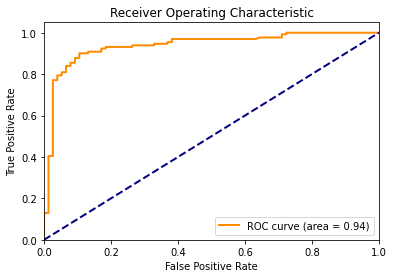

In [34]:
# Calculate the probabilities of the classes
y_prob = rf_random.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('roc_curve.pdf')
plt.show()

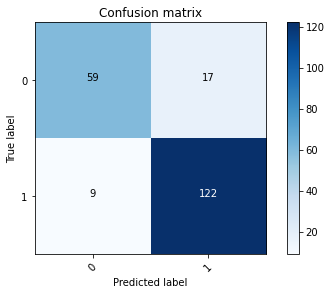

In [35]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define a custom function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1])
plt.savefig('confusion_matrix.pdf')
plt.show()